<B>Introduction :
This project aims to analyze the trend in tweets related to the recession from October 2022 to December 2022, with a focus on identifying instances of layoffs. The study will use data from tweets during this time period to understand the current state of the recession and any potential impacts on employment.

Dataset is taken from Kaggle : https://www.kaggle.com/datasets/sreevaatsavbavana/recession-tweets-latest
This dataset includes tweets from users discussing the current global recession. It provides a glimpse into the trends and current state of the recession as perceived by various individuals. The data was collected using various data scraping libraries

In [1]:
# Import libraries
import spacy
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from ekphrasis.classes.segmenter import Segmenter
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import nltk
from textblob import TextBlob


In [2]:
# Read Dataset
df = pd.read_csv('recession_tweets_oct_dec_22.csv')

In [3]:
# Print head of the dataset
df.head()

,Unnamed: 0,Date,User,Tweet,likeCount,replyCount,retweetCount,location
0,0,2022-12-13 23:47:18+00:00,NickMorenoLive,They are barking loud now that they can't pay ...,0,0,0,United States
1,1,2022-12-13 23:46:49+00:00,InvariantPersp1,#recession ... #GFC2 US #CPI #Consumer #Inflat...,2,0,0,NaN
2,2,2022-12-13 23:46:02+00:00,FXStreetNews,GBP/JPY eyes downside to near 167.00 as furthe...,2,0,0,Barcelona
3,3,2022-12-13 23:37:23+00:00,Frugalology,Frugal Tips on How to Save Money on Groceries ...,0,0,0,Texas
4,4,2022-12-13 23:36:55+00:00,FrugalMag,Frugal Tips on How to Save Money on Groceries ...,0,0,0,Texas


In [4]:
df.shape

(34850, 8)

We can see that there are 34850 records and 8 columns


In [5]:
source_nlp = spacy.load('en_core_web_sm')
seg_tw = Segmenter(corpus= "twitter")


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/Users/akanksha/opt/anaconda3/envs/Ml/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [6]:
df.describe()

,Unnamed: 0,likeCount,replyCount,retweetCount
count,34850.000000,34850.000000,34850.000000,34850.000000
mean,17424.500000,4.146772,0.542669,1.058049
std,10060.472777,51.451684,5.858551,10.836371
min,0.000000,0.000000,0.000000,0.000000
25%,8712.250000,0.000000,0.000000,0.000000
50%,17424.500000,0.000000,0.000000,0.000000
75%,26136.750000,1.000000,0.000000,0.000000
max,34849.000000,4696.000000,439.000000,1103.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34850 entries, 0 to 34849
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    34850 non-null  int64 
 1   Date          34850 non-null  object
 2   User          34850 non-null  object
 3   Tweet         34850 non-null  object
 4   likeCount     34850 non-null  int64 
 5   replyCount    34850 non-null  int64 
 6   retweetCount  34850 non-null  int64 
 7   location      22019 non-null  object
dtypes: int64(4), object(4)
memory usage: 2.1+ MB


In [8]:
#convert date to date datetime format
df['Date_'] = pd.to_datetime(df['Date'])

In [9]:
#Extract the month from date
df['month'] = df['Date_'].dt.month

In [10]:
# Let's see the months for the tweets
df['month'].value_counts()

10    15037
11    14498
12     5315
Name: month, dtype: int64

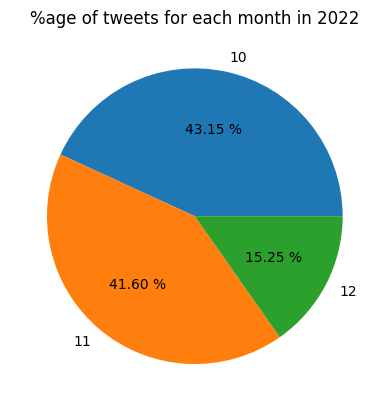

In [11]:
# Let's plot the percentage tweets for each month
a = dict(df['month'].value_counts())
plt.pie(a.values(),labels =a.keys(),autopct = '%.2f %%' )
plt.title('%age of tweets for each month in 2022')
plt.show()


We can see that there are very few tweet for the December month. This can be the case because the data set is prepared around 15th December.




Let's see the data for some tweets.

In [12]:
df.iloc[0]['Tweet']

"They are barking loud now that they can't pay even the interest on their debt. It will be interesting to see who Biden gives this company to when he bails em out.\n\n#BlackRock\n#recession \n#interestrates https://t.co/nkz2xnshoU"

In [13]:
#Let's preprocess the data and remove certain words
df['hashtag'] = df['Tweet'].apply(lambda x : re.findall(r"#(\w+)",x))


In [14]:
# Let's find out most frequent words which are present in the tweets
tweet_All = " ".join(twe for twe in df.Tweet)
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, 
                          background_color="white").generate(tweet_All)

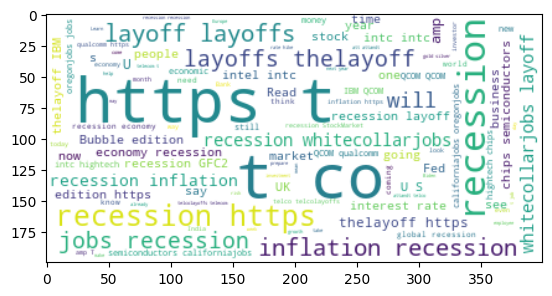

In [15]:
plt.imshow(wordcloud_ALL, interpolation='bilinear')

We can see that recession, inflation , layoofs are most common words which is as expected because we are trying to analyse the data related to recessions

Note : This word cloud is created using the raw data and hence we can see https in the word cloud. In next steps, we will remove these from our dataset.

<h2>Preprocessing Tweets

In [16]:
#We need to remove these strings from our datset
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# Let's create a function to remove these characters from the tweets
def remove_punctuation(text):
    s = ''.join([a for a in text if a not in string.punctuation])
    s = re.sub('[0-9]+', '', s)
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"https\S+", "", s)
    s = re.sub(r"www.\S+", "", s)
    s = re.sub('\\n\\n', "", s)
    s = s.lower()
    return(s)


In [18]:
df['Tweet_punc'] = df['Tweet'].apply(lambda x:remove_punctuation(x))

In [19]:
df['Tweet_Token'] = df['Tweet_punc'].apply(lambda x: re.split(r"(\w+)",x.lower()))

In [20]:
# creating stopwords variable from the nltk library
stopwords = nltk.corpus.stopwords.words('english')

Removing stopwords from the dataset

In [21]:
df['Tweet_Token'] = df['Tweet_Token'].apply(lambda x: ''.join([a for a in x if a not in stopwords]))

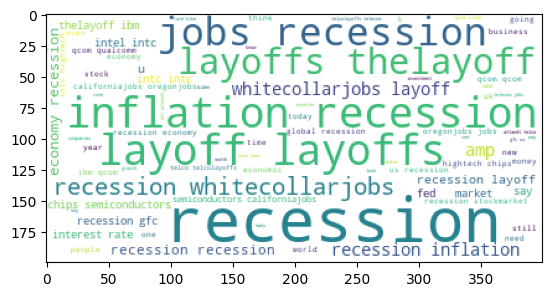

In [22]:
# Let's create the wordcloud from the preprocessed dataset
tweet_Token_All = " ".join(twe for twe in df.Tweet_Token)
wordcloud_Token_ALL = WordCloud(max_font_size=50, max_words=100, 
                          background_color="white").generate(tweet_Token_All)
plt.imshow(wordcloud_Token_ALL)

We can see that in these there are new words which popped up and were not there in the last wordcloud.   
amp.  
whitecollar jobs  
intel     


In [23]:
# While working on the raw data I found out certain emoticons which we need to remove from our dataset
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [24]:
df['Tweet_Token'] = df['Tweet_Token'].apply(lambda x : remove_emoji(x))

<H3> Stemming (Porter)

In [25]:
ps = nltk.PorterStemmer()

In [26]:
def stemmer(string):
    return(ps.stem(string))
df['Twitter_stem'] = df['Tweet_Token'].apply(lambda x : stemmer(x))

<h3>Lemmatization

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akanksha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
wl = nltk.WordNetLemmatizer()

In [29]:
def lemmatization(string):
    return(wl.lemmatize(string))

In [30]:
df['Tweet_Lemma'] = df['Tweet_Token'].apply(lambda x :lemmatization(x) )

In [31]:
df[df['User'].str.contains('frugal',regex = True,case = False)][['User','hashtag']]

,User,hashtag
3,Frugalology,"[frugal, frugaltips, inflation, recession, sav..."
4,FrugalMag,"[frugal, frugaltips, inflation, recession, sav..."
23888,frugal_friends_,"[Minimalist, recession, MoneyTalks, frugal]"
26364,StuFrugal,[recession]
26375,frugal_friends_,"[Minimalist, recession, MoneyTalks, frugal]"
27189,frugal_friends_,"[Minimalist, recession, MoneyTalks, frugal]"


We can see that in some hashtags the user name is also present which is not repersenting the dataset correctly. Let's remove these from our dataset and analyse the data

In [32]:
def remove_hashtag_like_username(string):
    final = ''
    #print(string[0],string[1])
    for wrd in string[0]:
        
        if re.search(wrd+'\w+',string[1],re.IGNORECASE):
            continue
        else:
            
            final = final + ' ' + wrd
    return(final)

In [33]:
df['hashtag'] = df[['hashtag','User']].apply(remove_hashtag_like_username,axis = 1)

Remove this for all the records

<h2> Sentiment Analysis

Let's do the the setiment anlysis of the tweets 

In [34]:
df['sentiment'] = df['Tweet_Token'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,Unnamed: 0,Date,User,Tweet,likeCount,replyCount,retweetCount,location,Date_,month,hashtag,Tweet_punc,Tweet_Token,Twitter_stem,Tweet_Lemma,sentiment
0,0,2022-12-13 23:47:18+00:00,NickMorenoLive,They are barking loud now that they can't pay ...,0,0,0,United States,2022-12-13 23:47:18+00:00,12,BlackRock recession interestrates,they are barking loud now that they cant pay e...,barking loud cant pay even interest de...,barking loud cant pay even interest de...,barking loud cant pay even interest de...,0.3
1,1,2022-12-13 23:46:49+00:00,InvariantPersp1,#recession ... #GFC2 US #CPI #Consumer #Inflat...,2,0,0,NaN,2022-12-13 23:46:49+00:00,12,recession GFC2 CPI Consumer Inflation deflati...,recession gfc us cpi consumer inflation editi...,recession gfc us cpi consumer inflation editi...,recession gfc us cpi consumer inflation editi...,recession gfc us cpi consumer inflation editi...,0.0
2,2,2022-12-13 23:46:02+00:00,FXStreetNews,GBP/JPY eyes downside to near 167.00 as furthe...,2,0,0,Barcelona,2022-12-13 23:46:02+00:00,12,GBPJPY BOE BOJ Recession Inflation,gbpjpy eyes downside to near as further boe r...,gbpjpy eyes downside near boe rate hike b...,gbpjpy eyes downside near boe rate hike b...,gbpjpy eyes downside near boe rate hike b...,0.1
3,3,2022-12-13 23:37:23+00:00,Frugalology,Frugal Tips on How to Save Money on Groceries ...,0,0,0,Texas,2022-12-13 23:37:23+00:00,12,frugaltips inflation recession savemoneyongro...,frugal tips on how to save money on groceries ...,frugal tips save money groceries inflatio...,frugal tips save money groceries inflatio...,frugal tips save money groceries inflatio...,0.0
4,4,2022-12-13 23:36:55+00:00,FrugalMag,Frugal Tips on How to Save Money on Groceries ...,0,0,0,Texas,2022-12-13 23:36:55+00:00,12,frugaltips inflation recession savemoneyongro...,frugal tips on how to save money on groceries ...,frugal tips save money groceries inflatio...,frugal tips save money groceries inflatio...,frugal tips save money groceries inflatio...,0.0


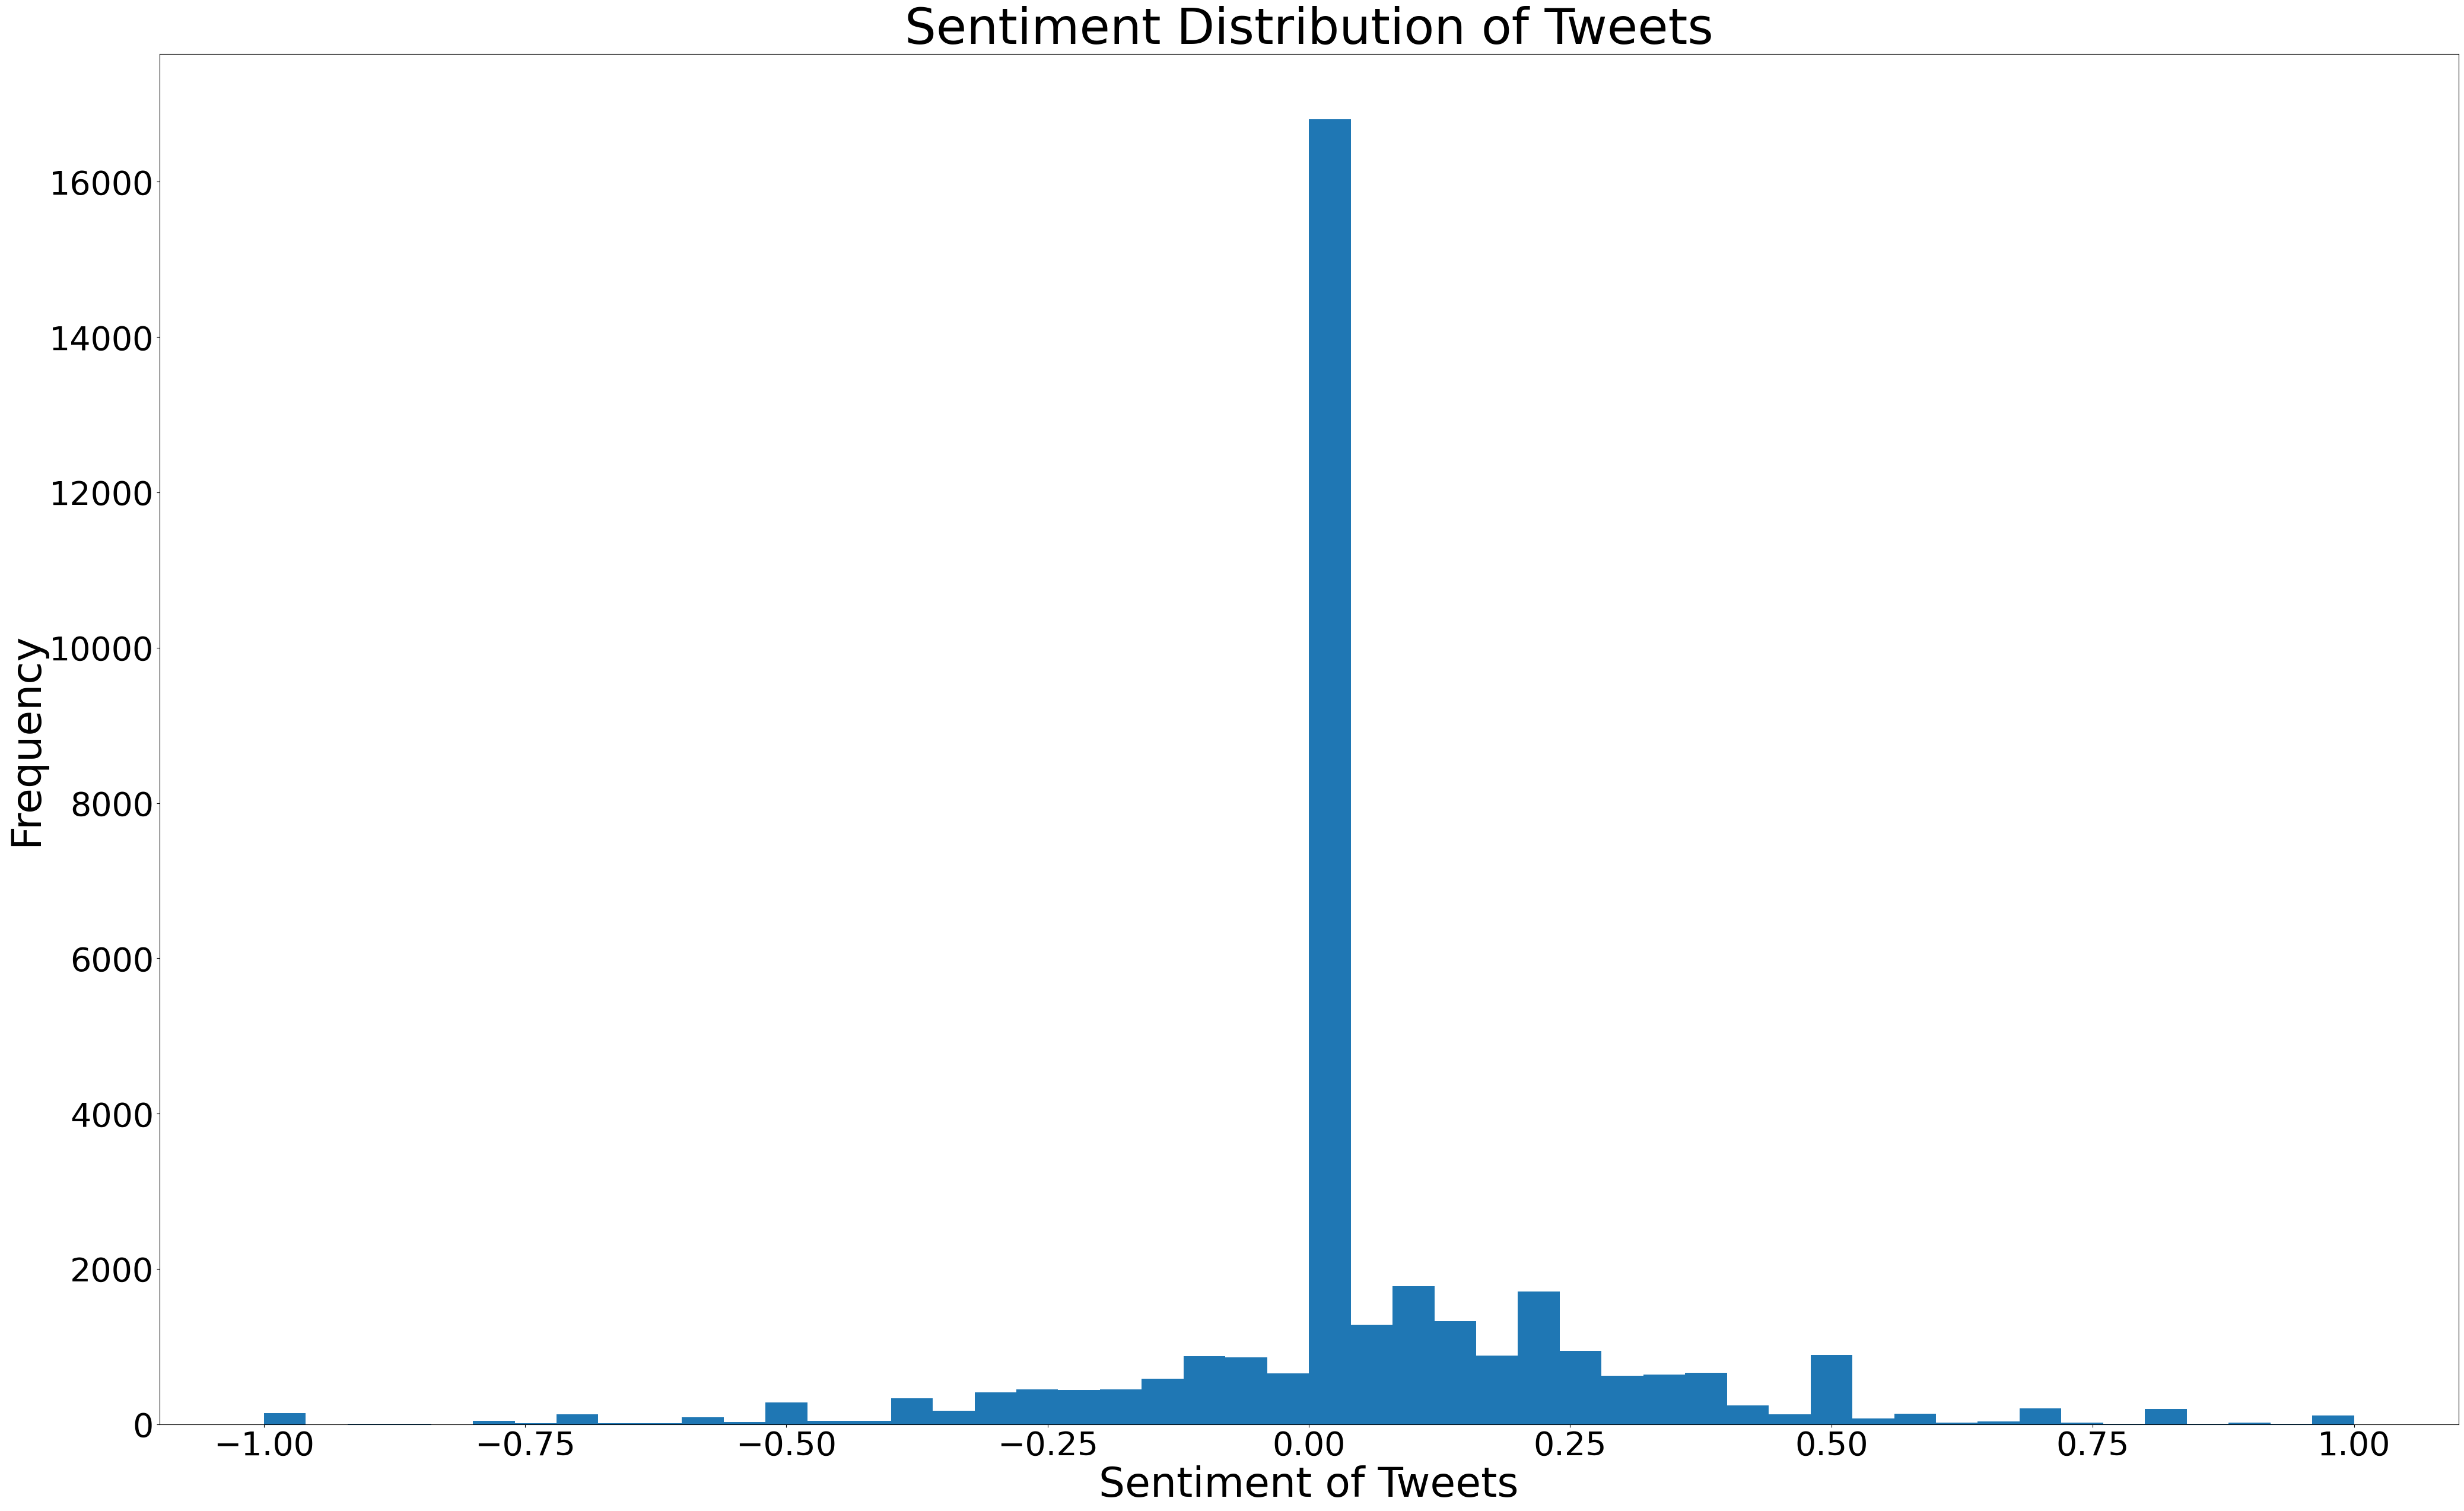

In [35]:
# Distribution of the sentiments of the tweets
plt.figure(figsize=(50,30))
plt.hist(df['sentiment'], bins=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.xlabel('Sentiment of Tweets', fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.title('Sentiment Distribution of Tweets', fontsize=60)
plt.show()

We can see that there are some tweets whose sentiment is 1. It's intersting to explore those tweets and see why they are there in the first place in the recession dataset.

### Analysis of Tweets where sentiment is 1

In [36]:
df[df['sentiment'] == max(df['sentiment'])]['Tweet']

511      With a #recession imminent it's the perfect ti...
560      Don't let a #recession ruin your #sales! \nThe...
582      Netflix stock is the ‘best recession play’ for...
703      Best Graphics of 2022, No. 19: The Biden clima...
1448     Recessions are the perfect time to move from a...
                               ...                        
32721    Posthaste: #Canada versus #USA — Which country...
32873    #Canada versus the #US: Which country will cou...
33183    Best guess $DXY 109-110 ➡️ 120-123, that is al...
33301    $FFIE perfect set up.\nCOME ON PEOPLE LET'S PU...
34577    The best domain name in the world is for sale ...
Name: Tweet, Length: 114, dtype: object

In [37]:
df.iloc[511]['Tweet']

"With a #recession imminent it's the perfect time to get an #ebike that doesn't require license, registration, or insurance to get around town. https://t.co/be409lkeVg"

In [38]:
df.iloc[560]['Tweet']

"Don't let a #recession ruin your #sales! \nThe #holiday season is coming up, and it's the perfect time to grow your #business. \n\nJoin us on December 15th at 3PM ET for our #webinar on Generating Sales During a Recession with Rebecca Parry, Sales Coach.\nhttps://t.co/mEKQSvsNlD"

In [39]:
df.iloc[1448]['Tweet']

'Recessions are the perfect time to move from a place of offense and strategy, not fear.\n\n#RecessionStrategy #OpportunityInRecession #BusinessAdaptability #OvercomingChallenges #SuccessInToughTimes #ForwardThinking #SurvivingRecession #ResilientBusiness #BusinessInsight #recession'

### Analysis of tweet where sentiment is -1

In [40]:
df[df['sentiment'] == min(df['sentiment'])]['Tweet']

356      https://t.co/szZG7A4j4p\nVMware\nWorst of the ...
656      Economy rebounds, outlook remains bleak\n#holi...
658      UK economy rebounds from royal funeral hit, ou...
717      Despite President Joe Biden championing his re...
1039     #BLACKROCK ALERT🚨: THE WORST #RECESSION in HIS...
                               ...                        
34204    Q3 Wrap Up - The 2nd Worst Year for Investors ...
34283    #ConservativesI I definitely the #nasty #party...
34418    Hey @POTUS , this is your idea of “not being i...
34550    Europe Faces WORST Energy Crisis in History!\n...
34815    https://t.co/Fvnrtw0PaY\n\nBiden is the worst ...
Name: Tweet, Length: 144, dtype: object

In [41]:
df.iloc[356]['Tweet']

'https://t.co/szZG7A4j4p\nVMware\nWorst of the worst\n#vmware #dell #broadcom $vmw #vmw #hightech #software #virtualization #virtualizationjobs #jobs #recession #whitecollarjobs #layoff #layoffs #thelayoff 🤖'

In [42]:
df.iloc[656]['Tweet']

'Economy rebounds, outlook remains bleak\n#holidayseason #Holidays #recession #queenelizabeth #uk @ONS #ONS #asiantrader #IndustryNews\nhttps://t.co/LHyBC2V2LR'

In [43]:
df.iloc[34418]['Tweet']

'Hey @POTUS , this is your idea of “not being in a #recession” ? Prices are insane and nothing is being done to fix it. https://t.co/8aNTPc7wFc'

In [44]:
df['Tweet_len'] = df['Tweet_Token'].astype(str).apply(len)

In [45]:
df['Tweet_len'].mean()

142.686456241033